In [1]:
import numpy as np
import pandas as pd
from lifelines import NelsonAalenFitter
from sklearn.utils import check_random_state
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import random
from pprint import pprint
import seaborn as sns
import pdb
sns.set_style(style="whitegrid")
from matplotlib import rcParams

%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

In [2]:
class Node:
    def __init__(self, split_var=None, split_val=None, left=None, right=None,score=0):
        self.score=score 
        self.split_val=split_val
        self.split_var=split_var
        self.left = left
        self.right = right
        self.chf = None
        self.terminal = False
        
    def is_leaf_node(self):
        return self.terminal is True
    
class SurvivalTree:
    
    def __init__(self, f_idxs, n_features, random_instance, timeline, unique_deaths=1, min_leaf=1, max_depth=None):
        
        self.max_depth = max_depth if max_depth is not None else float("inf")
        self.n_features=n_features
        self.root=None
        self.min_leaf = min_leaf
        self.unique_deaths = unique_deaths
        self.timeline = timeline
        self.f_idxs=f_idxs
        self.random_instance = random_instance
        self.chf=None
        self.index=0
        self.depth=0
        
    def fit(self, x, y):
        self.root, self.depth = self._grow_tree(x, y, f_idxs=self.f_idxs)
        
    def _grow_tree(self, x, y, f_idxs, depth=0):
        feat_idxs=[]
        n_samples,n_feature=x.shape
        
        # check the stopping criteria
        if n_samples<=1:
            leaf_node = self.compute_terminal_node(y)
            return leaf_node , depth
        
        n_features = int(round(np.sqrt(n_feature), 0))
        if len(f_idxs)==0:
            f_idxs=self.random_instance.permutation(n_feature)[:n_features]
        score, split_val, split_var, lhs_idxs_opt, rhs_idxs_opt = self._find_split(x, y, f_idxs)
        
        if split_var is not None:
            left, d_left = self._grow_tree(x.iloc[lhs_idxs_opt, :], y.iloc[lhs_idxs_opt, :],feat_idxs, depth+1)
            right, d_right = self._grow_tree(x.iloc[rhs_idxs_opt, :], y.iloc[rhs_idxs_opt, :],feat_idxs, depth+1)
            return Node(split_var, split_val, left, right,score), max(d_left,d_right)
        else:
        # If no suitable split is found, return a leaf node
            return self.compute_terminal_node(y), depth
    
    def _find_split(self, x, y, feat_idxs):
        score_opt = 0
        split_val_opt = None
        lhs_idxs_opt = None
        rhs_idxs_opt = None
        split_var_opt = None
        for i in feat_idxs:
            score, split_val, lhs_idxs, rhs_idxs = self._find_best_split_for_variable(x, y, i)

            if score > score_opt:
                score_opt = score
                split_val_opt = split_val
                lhs_idxs_opt = lhs_idxs
                rhs_idxs_opt = rhs_idxs
                split_var_opt = i

        return score_opt, split_val_opt, split_var_opt, lhs_idxs_opt, rhs_idxs_opt
    
    
    def _find_best_split_for_variable(self, X, y, var_idx):
      
        score, split_val, lhs_idxs, rhs_idxs = self.logrank_statistics(X, y,feature=var_idx,min_leaf=self.min_leaf)
        return score, split_val, lhs_idxs, rhs_idxs
    
    def logrank_statistics(self, x, y, feature, min_leaf):
     
        x_feature = x.reset_index(drop=True).iloc[:, feature]
        score_opt = 0
        split_val_opt = None
        lhs_idxs = None
        rhs_idxs = None

        for split_val in x_feature.sort_values(ascending=True, kind="quicksort").unique():
            feature1 = list(x_feature[x_feature <= split_val].index)
            feature2 = list(x_feature[x_feature > split_val].index)
            if len(feature1) < min_leaf or len(feature2) < min_leaf:
                continue
            durations_a = np.array(y.iloc[feature1, 1])
            event_observed_a = np.array(y.iloc[feature1, 0])
            durations_b = np.array(y.iloc[feature2, 1])
            event_observed_b = np.array(y.iloc[feature2, 0])
            score = logrank_test(durations_a, durations_b, event_observed_a, event_observed_b).test_statistic
            if score > score_opt:
                score_opt = round(score, 3)
                split_val_opt = round(split_val, 3)
                lhs_idxs = feature1
                rhs_idxs = feature2

        return score_opt, split_val_opt, lhs_idxs, rhs_idxs

    def predict(self, x):
        node=self.root
        c=self.predict_chf(x,node)
        return self.chf
    
    def predict_chf(self, x, node):
        """
        Predict the cumulative hazard function if its a terminal node. If not walk through the tree.
        :param x: The input sample.
        :return: Predicted cumulative hazard function if terminal node
        """
        if node is not None and node.terminal:
            self.chf = node.chf.cumulative_hazard_
            self.chf = self.chf.iloc[:, 0]
            return self.chf.dropna()

        elif node is not None:
            if x[node.split_var] <= node.split_val:
                return self.predict_chf(x,node.left)
            else:
                return self.predict_chf(x,node.right)
    
    def compute_terminal_node(self,y):
 
        leaf=Node()
        leaf.terminal = True
        t = y.iloc[:, 1]
        e = y.iloc[:, 0]
        leaf.chf = NelsonAalenFitter()
        leaf.chf.fit(t, event_observed=e, timeline=self.timeline)
        return leaf

In [3]:
class RandomSurvivalForest:

    def __init__(self, n_estimators: int = 100,max_depth=None, min_leaf: int = 3, unique_deaths: int = 3, subspace:int =256,
                 oob_score: bool = False, timeline=None, random_state=None, n_jobs: int or None = None):
  
        self.n_estimators = n_estimators
        self.max_depth = max_depth if max_depth is not None else float("inf")
        self.min_leaf = min_leaf
        self.subspace=subspace
        self.unique_deaths = unique_deaths
        self.bootstrap_idxs = None
        self.bootstraps = []
        self.oob_idxs = None
        self.oob_score = oob_score
        self.trees = []
        self.trees_depth = []
        self.timeline = timeline
        self.random_state = random_state
        self.random_instance = check_random_state(self.random_state)
        self.n_jobs = n_jobs

    def fit(self, x, y):
    
        n_trees = []
        n_depth = []
        try:
            if self.timeline is None:
                self.timeline = y.iloc[:, 1].sort_values().unique()
        except Exception:
            raise (
                "Timeline seems to contain float values. Please provide a custom timeline in the RandomSurvivalForest "
                "constructor. "
                "For example: RandomSurivalForest(timeline=range(y.iloc[:, 1].min(), y.iloc[:, 1].max(), 0.1)")
            
        self.bootstrap_idxs = self._draw_bootstrap_samples(x)
        for i in range(self.n_estimators):
            X_sample, y_sample = x.iloc[self.bootstrap_idxs[i], :], y.iloc[self.bootstrap_idxs[i],:]
            n_features = int(round(np.sqrt(x.shape[1]), 0))
            f_idxs = self.random_instance.permutation(x.shape[1])[:n_features]
            tree = SurvivalTree(f_idxs=f_idxs, n_features=n_features, random_instance=self.random_instance,
                                timeline=self.timeline, unique_deaths=self.unique_deaths,
                                min_leaf=self.min_leaf,max_depth=self.max_depth)
            tree.fit(X_sample,y_sample)
            n_trees.append(tree)
            n_depth.append(tree.depth)
                                                                           
        for i in range(len(n_trees)):
            if n_trees[i].root is not None:
                self.trees.append(n_trees[i])
                self.bootstraps.append(self.bootstrap_idxs[i]) 
                self.trees_depth.append(n_depth[i])
        
                                                                           
        if self.oob_score:
            self.oob_score = self.compute_oob_score(x, y)
            
    def depth_tree(self):
        return self.trees_depth
    
    def _draw_bootstrap_samples(self, data):
        
        bootstrap_idxs = []
        for i in range(self.n_estimators):
            no_samples = len(data)
            data_rows = range(no_samples)
            bootstrap_idx = self.random_instance.choice(data_rows, min(self.subspace,no_samples))
            bootstrap_idxs.append(bootstrap_idx)

        return bootstrap_idxs
    
    def _compute_oob_ensembles(self, xs):
        """
        Compute OOB ensembles.
        :return: List of oob ensemble for each sample.
        """
        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._compute_oob_ensemble_chf)(sample_idx, xs, self.trees, self.bootstraps) for sample_idx in
            range(xs.shape[0]))
        oob_ensemble_chfs = [i for i in results if not i.empty]
        return oob_ensemble_chfs

    def compute_oob_score(self, x, y):
        """
        Compute the oob score (concordance-index).
        :return: c-index of oob samples
        """
        oob_ensembles = self._compute_oob_ensembles(x)
        c = concordance_index(y_time=y.iloc[:, 1], y_pred=oob_ensembles, y_event=y.iloc[:, 0])
        return c

    def predict(self, xs):
        """
        Predict survival for xs.
        :param xs: The input samples
        :return: List of the predicted cumulative hazard functions.
        """
        ensemble_chfs = [self._compute_ensemble_chf(sample_idx=sample_idx, xs=xs, trees=self.trees)
                         for sample_idx in range(xs.shape[0])]
        
        return ensemble_chfs

    def _compute_ensemble_chf(self, sample_idx: int, xs, trees: list):
        denominator = 0
        numerator = 0
        for b in range(len(trees)):
            sample = xs.iloc[sample_idx].to_list()
            chf = trees[b].predict(sample)
            denominator = denominator + 1
            numerator = numerator + 1 * chf
        ensemble_chf = numerator / denominator
        return ensemble_chf
    
    def _path_(self,x,node,path):
        if(node is None):
            return path
        path=path+1
        if node.is_leaf_node():
            return path
        if x.iloc[0, node.split_var] <= float(node.split_val):
            return self._path_(x,node.left,path)
        elif x.iloc[0, node.split_var] > float(node.split_val):
            return self._path_(x,node.right,path)
        return path
        
    def pathLength(self,example,iTree):
        return self._path_(example,iTree.root,path=0)
        
    def evaluate_instance(self,instance):
        paths = []
        for tree in self.trees:
            paths.append(self.pathLength(instance,tree))
        return paths 
    
    def c_factor(self) :
        return 2.0*(np.log(self.subspace-1)+0.5772156649) - (2.0*(self.subspace-1.)/(self.subspace*1.0))
    
    def anomaly_score(self,data_point):

        # Mean depth for an instance
        E = np.mean(self.evaluate_instance(data_point))

        c = self.c_factor()

        return 2**-(E/c)
    
    def decisionScore(self,X):
        decision_score= []
        for i in range(X.shape[0]):
            decision_score.append(self.anomaly_score(X.iloc[[i]]))
        return decision_score
    
    def predict_out(self,X,contamination):
        decision_score=self.decisionScore(X)
        prediction = []
        total_contamination = int(contamination * len(decision_score))
        anomaly_score = np.sort(np.array(decision_score))[::-1]
        anomaly_score = anomaly_score[:total_contamination]
        for score in decision_score:
            if score in anomaly_score:
                prediction.append(-1)
            else:
                prediction.append(1)
        return prediction

    def _compute_oob_ensemble_chf(self, sample_idx: int, xs, trees: list, bootstraps: list):
        denominator = 0
        numerator = 0
        for b in range(len(trees)):
            if sample_idx not in bootstraps[b]:
                sample = xs.iloc[sample_idx].to_list()
                chf = trees[b].predict(sample)
                denominator = denominator + 1
                numerator = numerator + 1 * chf
        if denominator != 0:
            oob_ensemble_chf = numerator / denominator
        else:
            oob_ensemble_chf = pd.Series()
        return oob_ensemble_chf

In [4]:
from itertools import combinations


def concordance_index(y_time, y_pred, y_event):
    """
    Compute concordance index.
    :param y_time: Actual Survival Times.
    :param y_pred: Predicted cumulative hazard functions.
    :param y_event: Actual Survival Events.
    :return: c-index.
    """
    predicted_outcome = [x.sum() for x in y_pred]
    possible_pairs = list(combinations(range(len(y_pred)), 2))
    concordance = 0
    permissible = 0
    for pair in possible_pairs:
        t1 = y_time.iat[pair[0]]
        t2 = y_time.iat[pair[1]]
        e1 = y_event.iat[pair[0]]
        e2 = y_event.iat[pair[1]]
        predicted_outcome_1 = predicted_outcome[pair[0]]
        predicted_outcome_2 = predicted_outcome[pair[1]]

        shorter_survival_time_censored = (t1 < t2 and e1 == 0) or (t2 < t1 and e2 == 0)
        t1_equals_t2_and_no_death = (t1 == t2 and (e1 == 0 and e2 == 0))

        if shorter_survival_time_censored or t1_equals_t2_and_no_death:
            continue
        else:
            permissible = permissible + 1
            if t1 != t2:
                if t1 < t2:
                    if predicted_outcome_1 > predicted_outcome_2:
                        concordance = concordance + 1
                        continue
                    elif predicted_outcome_1 == predicted_outcome_2:
                        concordance = concordance + 0.5
                        continue
                elif t2 < t1:
                    if predicted_outcome_2 > predicted_outcome_1:
                        concordance = concordance + 1
                        continue
                    elif predicted_outcome_2 == predicted_outcome_1:
                        concordance = concordance + 0.5
                        continue
            elif t1 == t2:
                if e1 == 1 and e2 == 1:
                    if predicted_outcome_1 == predicted_outcome_2:
                        concordance = concordance + 1
                        continue
                    else:
                        concordance = concordance + 0.5
                        continue
                elif not (e1 == 1 and e2 == 1):
                    if e1 == 1 and predicted_outcome_1 > predicted_outcome_2:
                        concordance = concordance + 1
                        continue
                    elif e2 == 1 and predicted_outcome_2 > predicted_outcome_1:
                        concordance = concordance + 1
                        continue
                    else:
                        concordance = concordance + 0.5
                        continue

    c = concordance / permissible

    return c

In [5]:
import time

from lifelines import datasets
from sklearn.model_selection import train_test_split


rossi = datasets.load_rossi()
# Attention: duration column must be index 0, event column index 1 in y
y = rossi.loc[:, ["arrest", "week"]]
X = rossi.drop(["arrest", "week"], axis=1)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

print("Start training...")
start_time = time.time()
rsf = RandomSurvivalForest(n_estimators=20, random_state=10)
rsf.fit(X, y)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 218.401 seconds ---


In [6]:
decision_score=rsf.decisionScore(X)

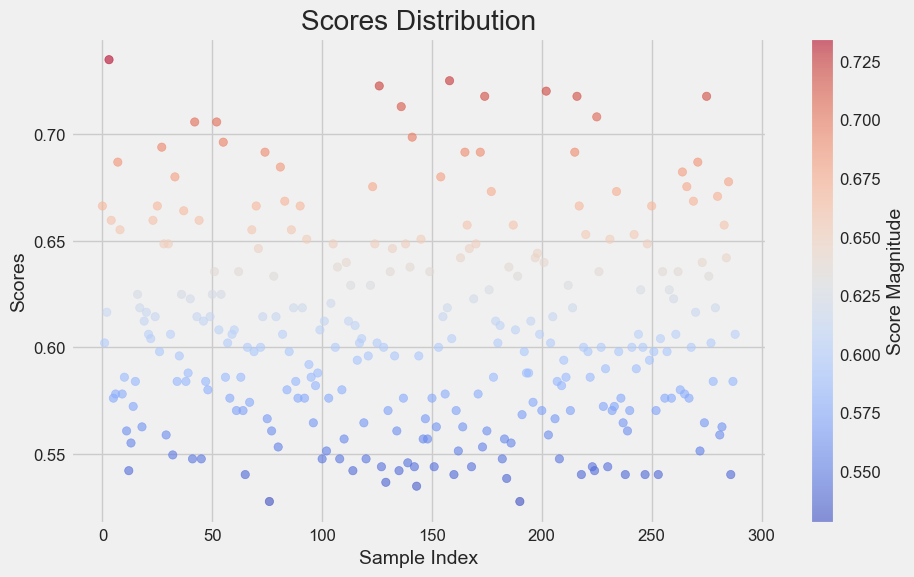

In [7]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

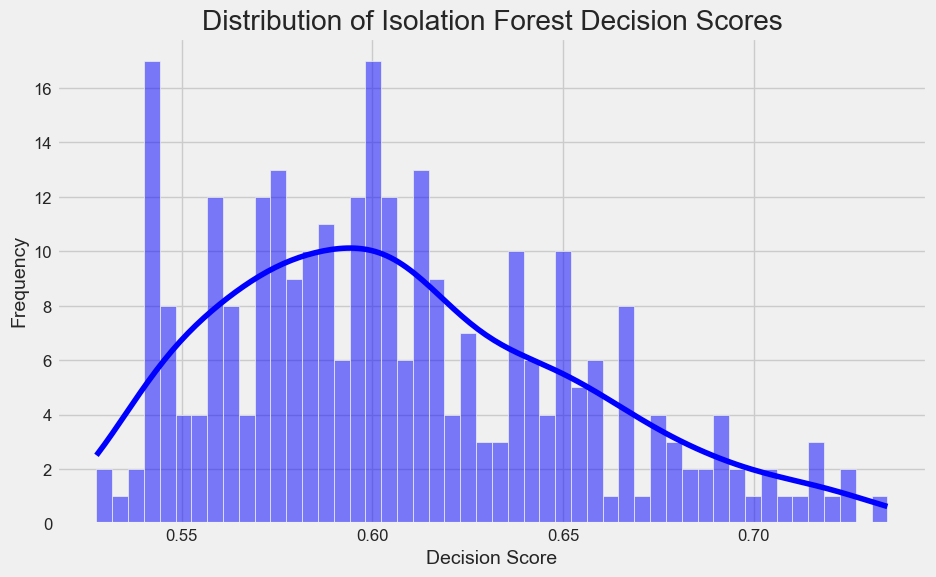

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Isolation Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
y_pred = rsf.predict(X)
c_val = concordance_index(y_time=y["week"], y_pred=y_pred, y_event=y["arrest"])
print(f'C-index {round(c_val, 3)}')

C-index 0.826


In [11]:
def convert_to_survival_function(chf_series):
    """
    Convert a Pandas Series representing a cumulative hazard function to a survival function.
    """
    survival_function = np.exp(-chf_series)
    return survival_function

In [14]:
prediction = rsf.predict_out(X,0.1)

In [15]:
# Survival function for Outliers
survival_functions_outliers = []
survival_functions_inliers = []
for i in range(len(prediction)):
    if prediction[i]==-1:
        survival_functions_outliers.append(convert_to_survival_function(y_pred[i]))
    else:
        survival_functions_inliers.append(convert_to_survival_function(y_pred[i]))


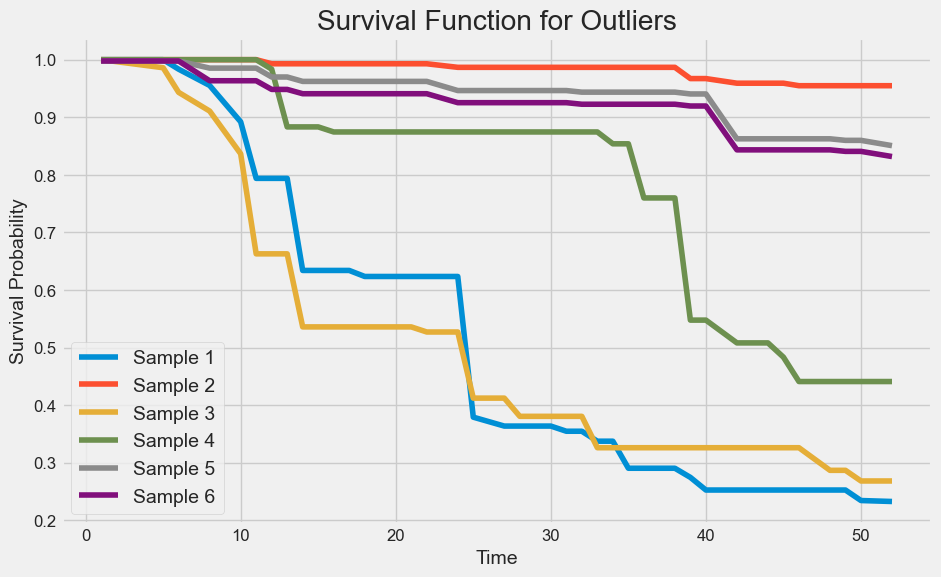

In [16]:
# Plot the survival functions
plt.figure(figsize=(10, 6))
for i, sf in enumerate(survival_functions_outliers):
    plt.plot(sf.index, sf.values, label=f'Sample {i+1}')
    if i==5:
        break

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Function for Outliers')
plt.legend()
plt.grid(True)
plt.savefig("survh_o.png")
plt.show()

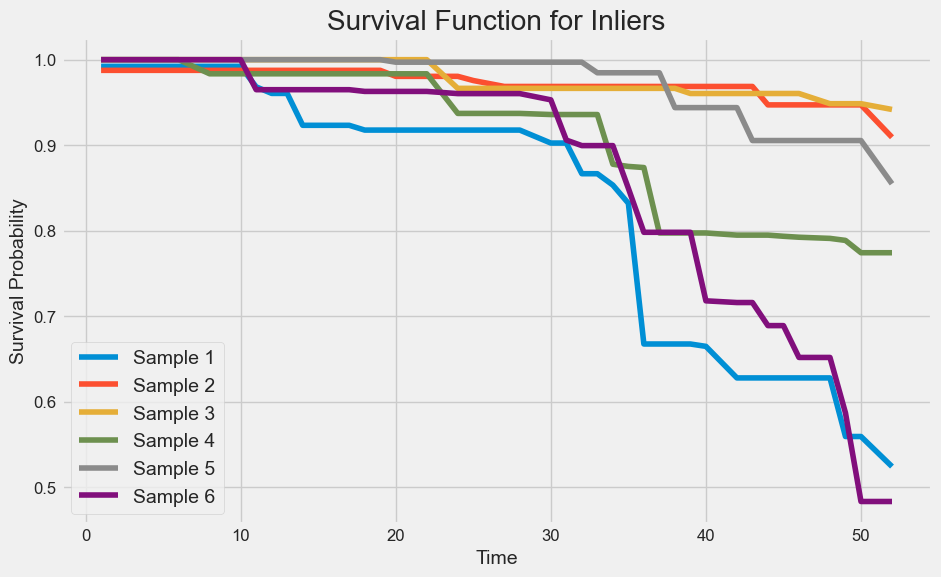

In [17]:
# Plot the survival functions
plt.figure(figsize=(10, 6))
for i, sf in enumerate(survival_functions_inliers):
    plt.plot(sf.index, sf.values, label=f'Sample {i+1}')
    if i==5:
        break

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Function for Inliers')
plt.legend()
plt.grid(True)
plt.savefig("survh_o.png")
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
import pandas as pd

X, y = load_gbsg2()
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

event_indicator_train = np.array(y_df["cens"], dtype=bool)
time_of_event_train = np.array(y_df["time"], dtype=float)

y_df = pd.DataFrame({'event': event_indicator_train, 'time': time_of_event_train})

## create an instance of the ordinalEncoder class and fit_transform
Oencoder = OrdinalEncoder(categories=[['I','II','III']])
grade_str = Oencoder.fit_transform(X_df[['tgrade']])
X_df = X_df.drop("tgrade", axis=1)

## create an instance of the OneHotEncoder class and fit_transform
oneHotEncoder = OneHotEncoder()
X_df = oneHotEncoder.fit_transform(X_df)
X_df['tgrade'] = grade_str

## splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, random_state=20)

In [19]:
print("Start training...")
start_time = time.time()
rsf_h = RandomSurvivalForest(n_estimators=10,random_state=20)
rsf_h.fit(X_train, y_train)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 696.875 seconds ---


In [20]:
decision_score=rsf_h.decisionScore(X_train)

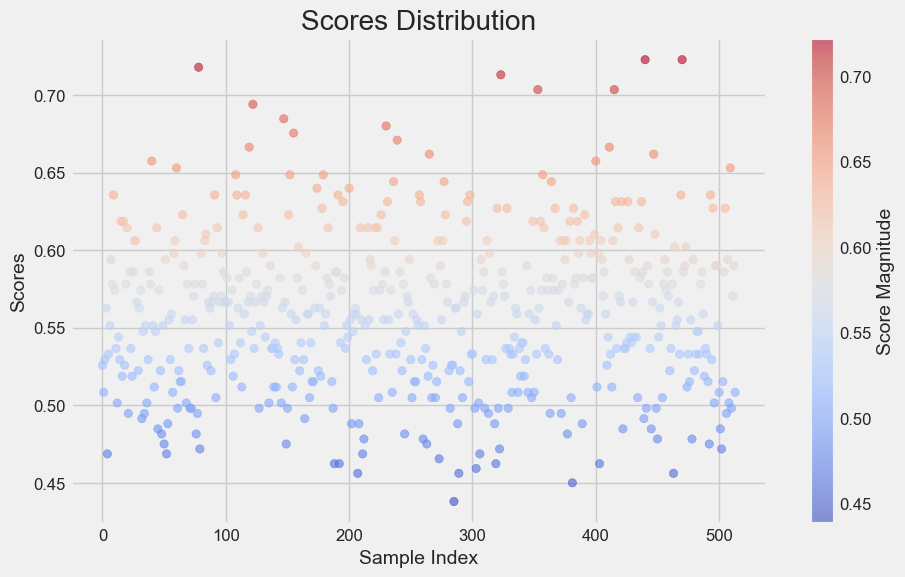

In [21]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.savefig("score_rsf.png")
plt.show()

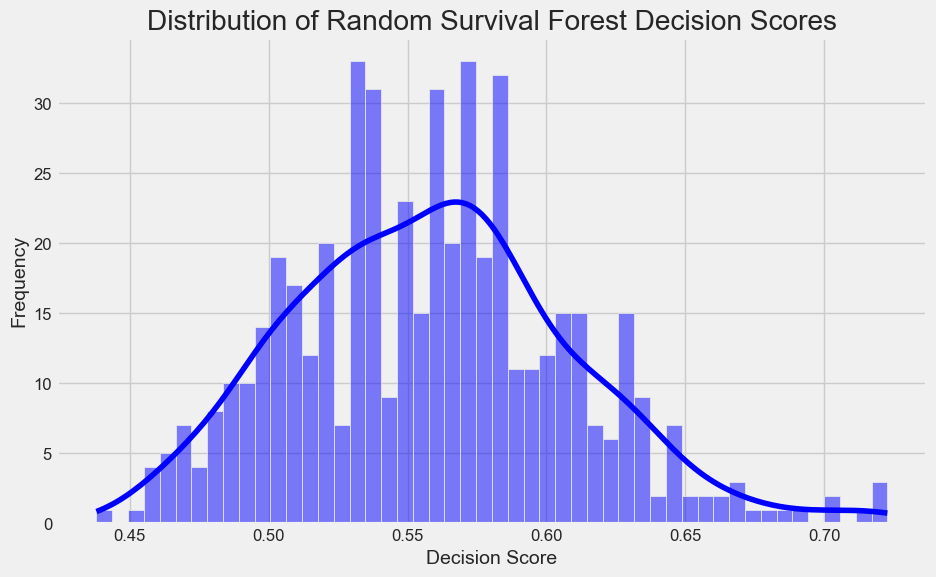

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Random Survival Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("dscore_rsf.png")
plt.show()

In [23]:
y_pred = rsf_h.predict(X_train)
c_val = concordance_index(y_time=y_train["time"], y_pred=y_pred, y_event=y_train["event"])
print(f'C-index {round(c_val, 3)}')

C-index 0.814


In [24]:
def convert_to_survival_function(chf_series):
    """
    Convert a Pandas Series representing a cumulative hazard function to a survival function.
    """
    survival_function = np.exp(-chf_series)
    return survival_function

In [25]:
prediction = rsf_h.predict_out(X_train,0.1)

In [26]:
# Survival function for Outliers
survival_functions_outliers = []
survival_functions_inliers = []
for i in range(len(prediction)):
    if prediction[i]==-1:
        survival_functions_outliers.append(convert_to_survival_function(y_pred[i]))
    else:
        survival_functions_inliers.append(convert_to_survival_function(y_pred[i]))

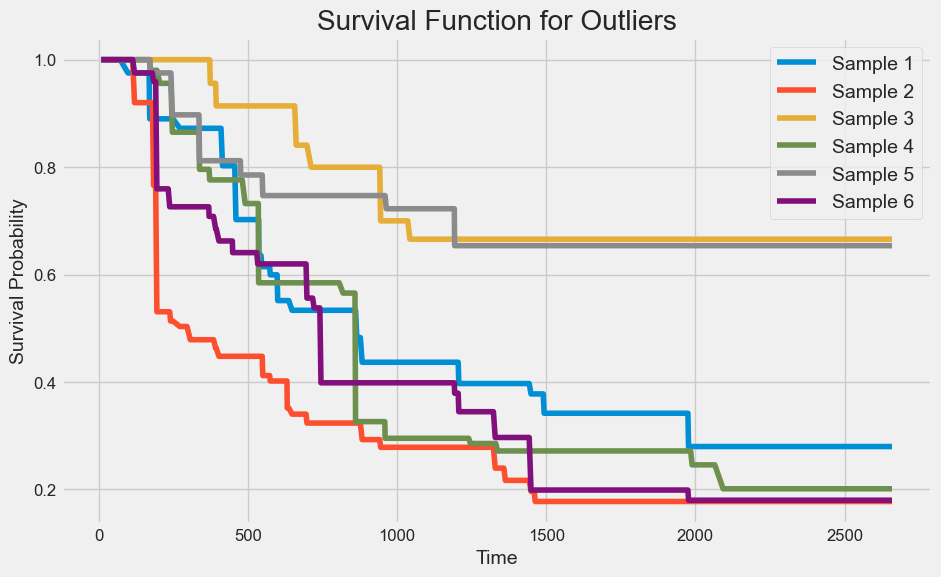

In [27]:
# Plot the survival functions
plt.figure(figsize=(10, 6))
for i, sf in enumerate(survival_functions_outliers):
    plt.plot(sf.index, sf.values, label=f'Sample {i+1}')
    if i==5:
        break

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Function for Outliers')
plt.legend()
plt.grid(True)
plt.savefig("surv_o.png")
plt.show()

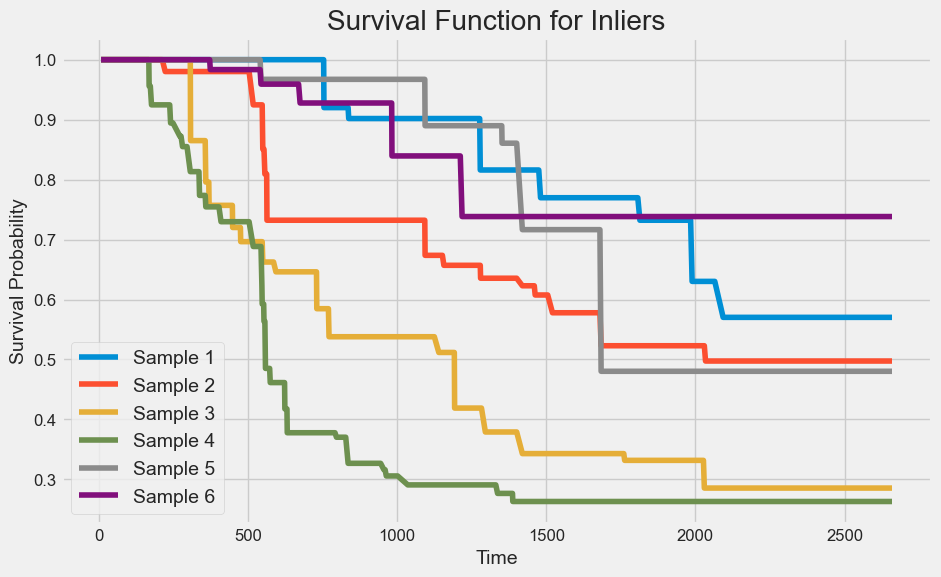

In [28]:
# Plot the survival functions
plt.figure(figsize=(10, 6))
for i, sf in enumerate(survival_functions_inliers):
    plt.plot(sf.index, sf.values, label=f'Sample {i+1}')
    if i==5:
        break

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Function for Inliers')
plt.legend()
plt.grid(True)
plt.savefig("surv_i.png")
plt.show()